### Importing Libraries

In [55]:
import gc #garbage collector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import random 
import lightgbm as lgb

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from helper import utility
import importlib
importlib.reload(utility)


<module 'helper.utility' from 'c:\\Users\\adeli\\ML\\CE4041_ML-1\\helper\\utility.py'>

### Importing Zillow Datasets

In [56]:
# Raw data set provided
prop_2016 = utility.load_data('data/properties_2016.csv')
prop_2017 = utility.load_data('data/properties_2017.csv')
train_2016 = utility.load_data('data/train_2016_v2.csv' , ['transactiondate'])
train_2017 = utility.load_data('data/train_2017.csv', ['transactiondate'])

In [57]:
# Combining the prop dataset with its corresponding train datasets on their parcelid
# left join is used so that all properties without logerror will be ignored
training_2016 = utility.merge_data(train_2016, prop_2016, 'parcelid')
training_2017 = utility.merge_data(train_2017, prop_2017, 'parcelid')



# Data across the 2 years are combined into one data frame for processing at later stages
training_all = pd.concat([training_2016, training_2017] , ignore_index=True)
properties_all = pd.concat([prop_2016, prop_2017], ignore_index=True) 


training_all
#properties_all.shape


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.027600,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.168400,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.004000,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.021800,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.005000,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167883,10833991,-0.002245,2017-09-20,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,NaN,NaN,265000.0,379000.0,2016.0,114000.0,4685.34,NaN,NaN,6.037132e+13
167884,11000655,0.020615,2017-09-20,NaN,NaN,NaN,2.0,2.0,NaN,6.0,...,NaN,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13
167885,17239384,0.013209,2017-09-21,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,1.0,NaN,50683.0,67205.0,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13
167886,12773139,0.037129,2017-09-21,1.0,NaN,NaN,1.0,3.0,NaN,4.0,...,NaN,NaN,32797.0,49546.0,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13


In [58]:
# Check and Drop any duplicates in the training dataset
# Duplicates are those which have the same parcelid and transactiondate

training_all.shape
utility.check_duplicates(training_all)
training_all = utility.drop_dups(training_all)

There are 0 duplicate IDs for 167888 total entries


In [59]:
# We can see that there are no duplicates in the dataset so far
training_all.shape

(167888, 60)

### Looking at the Target Variable - logerror

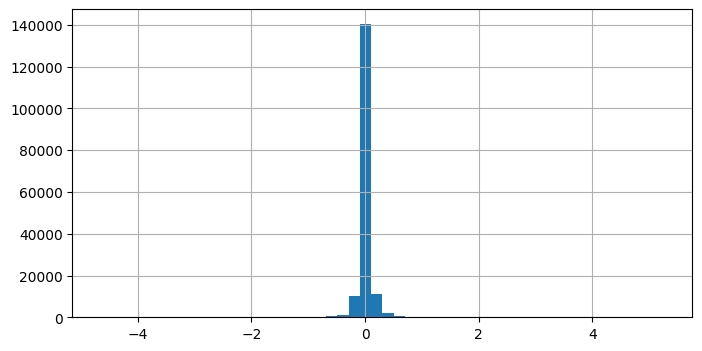

In [60]:
target_y = training_all['logerror']


target_y.hist(bins=50, figsize=(8,4))
plt.show()

In [61]:
target_y.describe()

count    167888.000000
mean          0.013906
std           0.165706
min          -4.655420
25%          -0.025300
50%           0.006000
75%           0.039200
max           5.262999
Name: logerror, dtype: float64

In [62]:
# Drop outliers that are more than 2.5 std away from mean
upper_threshold = target_y.mean() + (2.5*target_y.std())
lower_threshold = target_y.mean() - (2.5*target_y.std())


# Remove data that have their target y value as outliers
training_all = training_all[training_all['logerror'] < upper_threshold]
training_all = training_all[training_all['logerror'] > lower_threshold]
training_all.shape



(164566, 60)

### Data Preprocessing & Feature Engineering

In [63]:
# Adding Feature to the dataset
# Add Day, Month, Year and which quarter the transaction was done
training_all = utility.add_dmy_feature(training_all)
training_all

,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,quarter,day,transaction_year,transaction_month
0,11016594,0.027600,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,...,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13,1,1,2016,1
1,14366692,-0.168400,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,2015.0,239071.0,10153.02,NaN,NaN,NaN,1,1,2016,1
2,12098116,-0.004000,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,...,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13,1,1,2016,1
3,12643413,0.021800,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,...,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13,1,2,2016,1
4,14432541,-0.005000,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,...,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13,1,2,2016,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167883,10833991,-0.002245,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,2016.0,114000.0,4685.34,NaN,NaN,6.037132e+13,3,20,2017,9
167884,11000655,0.020615,NaN,NaN,NaN,2.0,2.0,NaN,6.0,2.0,...,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13,3,20,2017,9
167885,17239384,0.013209,NaN,NaN,NaN,2.0,4.0,NaN,NaN,2.0,...,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13,3,21,2017,9
167886,12773139,0.037129,1.0,NaN,NaN,1.0,3.0,NaN,4.0,1.0,...,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13,3,21,2017,9


In [64]:
utility.print_percent_missing(training_all)

buildingclasstypeid : 99.99%

finishedsquarefeet13 : 99.96%

basementsqft : 99.95%

storytypeid : 99.95%

yardbuildingsqft26 : 99.90%

fireplaceflag : 99.76%

architecturalstyletypeid : 99.72%

typeconstructiontypeid : 99.69%

finishedsquarefeet6 : 99.54%

decktypeid : 99.24%

pooltypeid10 : 99.03%

poolsizesum : 98.89%

pooltypeid2 : 98.64%

hashottuborspa : 97.67%

taxdelinquencyflag : 97.28%

taxdelinquencyyear : 97.28%

yardbuildingsqft17 : 96.98%

finishedsquarefeet15 : 96.21%

finishedfloor1squarefeet : 92.26%

finishedsquarefeet50 : 92.26%

fireplacecnt : 89.26%

threequarterbathnbr : 86.72%

pooltypeid7 : 81.01%

poolcnt : 79.64%

numberofstories : 77.19%

airconditioningtypeid : 67.76%

garagecarcnt : 66.75%

garagetotalsqft : 66.75%

regionidneighborhood : 60.21%

heatingorsystemtypeid : 37.04%

buildingqualitytypeid : 36.28%

propertyzoningdesc : 35.37%

unitcnt : 35.20%

lotsizesquarefeet : 11.05%

finishedsquarefeet12 : 4.79%

regionidcity : 1.98%

calculatedbathnbr : 1.02

In [65]:
# Drop all columns that have missing threashold greater than 95%
MISSING_THRESHOLD = 0.97
col_to_drop = utility.get_col_to_drop_missing(training_all, 0.95)
col_to_drop += utility.get_col_to_drop_non_unique(training_all)

# Other columns to exlude to prepare for training dataset
exclude_list = ["parcelid" , "logerror" , 'propertyzoningdesc']

remaining_col = []
for col in training_all.columns:
    if col not in col_to_drop and col not in exclude_list:
        remaining_col.append(col)
        print(col)

print('Number of columns left:', len(remaining_col))

18 has been flagged out

9 has been flagged out

airconditioningtypeid
bathroomcnt
bedroomcnt
buildingqualitytypeid
calculatedbathnbr
finishedfloor1squarefeet
calculatedfinishedsquarefeet
finishedsquarefeet12
finishedsquarefeet50
fips
fireplacecnt
fullbathcnt
garagecarcnt
garagetotalsqft
heatingorsystemtypeid
latitude
longitude
lotsizesquarefeet
propertycountylandusecode
propertylandusetypeid
rawcensustractandblock
regionidcity
regionidcounty
regionidneighborhood
regionidzip
roomcnt
threequarterbathnbr
unitcnt
yearbuilt
numberofstories
structuretaxvaluedollarcnt
taxvaluedollarcnt
assessmentyear
landtaxvaluedollarcnt
taxamount
censustractandblock
quarter
day
transaction_year
transaction_month
Number of columns left: 40


In [66]:
# Dealing with Categorical Values
# Convert categorical values to 'category' type for some columns

category_list= ['heatingorsystemtypeid','propertylandusetypeid', 'storytypeid', 
               'airconditioningtypeid', 'architecturalstyletypeid','typeconstructiontypeid'
                'buildingclasstypeid', 'quarter', 'day', 'transaction_year', 'transaction_day']
for col in training_all.columns:
    if col in category_list: 
        utility.float_to_categorical(training_all, col)


In [67]:
# Convert float64 values to float32 values 
# for col in training_all.columns: 
#     if training_all[col].dtype.name == 'float64': 
#         training_all[col] = training_all[col].astype('float32')

In [68]:
training_all.dtypes

parcelid                       int64
logerror                     float64
airconditioningtypeid       category
architecturalstyletypeid    category
basementsqft                 float64
                              ...   
censustractandblock          float64
quarter                     category
day                         category
transaction_year            category
transaction_month              int32
Length: 63, dtype: object

### Training models

In [69]:
# Drop unecessary columns, only keep the remaining columns 
training_cleaned=training_all

for col in training_all: 
    if col not in remaining_col: 
        training_cleaned=training_cleaned.drop([col], axis=1)

training_cleaned.head()
# for col in training_cleaned: 
#     training_cleaned[col] = training_cleaned[col].astype('category')
# training_cleaned.dtypes

,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet50,fips,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,quarter,day,transaction_year,transaction_month
0,0,2.0,3.0,4.0,2.0,NaN,1684.0,1684.0,NaN,6037.0,...,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13,0,0,0,1
1,-1,3.5,4.0,NaN,3.5,NaN,2263.0,2263.0,NaN,6059.0,...,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,0,0,0,1
2,0,3.0,2.0,4.0,3.0,NaN,2217.0,2217.0,NaN,6037.0,...,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13,0,0,0,1
3,0,2.0,2.0,4.0,2.0,NaN,839.0,839.0,NaN,6037.0,...,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13,0,1,0,1
4,-1,2.5,4.0,NaN,2.5,NaN,2283.0,2283.0,NaN,6059.0,...,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13,0,1,0,1


In [70]:
category_index = []
for i,col in enumerate(training_cleaned.columns): 
    if col in category_list: 
        category_index.append(i)
print(category_index)

[0, 14, 19, 36, 37, 38]


In [71]:
# Saving LightGBM models
def save_models(models):
    for i, model in enumerate(models):
        model.save_model('checkpoints/lgb_' + str(i))
    print("Saved {} LightGBM models to files.".format(len(models)))

# Load LightGBM models from files
def load_models(paths):
    models = []
    for path in paths:
        model = lgb.Booster(model_file=path)
        models.append(model)
    return models

In [72]:
lgb_label = training_all.logerror
lgb_label.head()

from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
lgb_X=ord_enc.fit_transform(training_cleaned)
#Transform to Numpy matrices 
#lgb_X = training_cleaned.values
lgb_y = lgb_label.values

# Perform shuffled train/test split
np.random.seed(42)
random.seed(10)
X_train, X_val, y_train, y_val = train_test_split(lgb_X, lgb_y, test_size=0.2)

# Remove outlier examples from X_train and y_train; Keep them in X_val and y_val for proper cross-validation
outlier_threshold = 0.4
mask = (abs(y_train) <= outlier_threshold)
X_train = X_train[mask, :]
y_train = y_train[mask]

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

X_train shape: (131440, 40)
y_train shape: (131440,)
X_val shape: (32914, 40)
y_val shape: (32914,)


In [73]:
params = {}

params['objective'] = 'regression'
params['metric'] = 'mae'
params['num_threads'] = 4  # set to number of real CPU cores for best performance

params['boosting_type'] = 'gbdt'
params['num_boost_round'] = 2000
params['learning_rate'] = 0.003  # shrinkage_rate
#params['early_stopping_rounds'] = 30  # Early stopping based on validation set performance

# Control tree growing
params['num_leaves'] = 127  # max number of leaves in one tree (default 31)
params['min_data'] = 150  # min_data_in_leaf
params['min_hessian'] = 0.001  # min_sum_hessian_in_leaf (default 1e-3)
params['max_depth'] = -1  # limit the max depth of tree model, defult -1 (no limit)
params['max_bin'] = 255  # max number of bins that feature values are bucketed in (small -> less overfitting, default 255)
params['sub_feature'] = 0.5    # feature_fraction (small values => use very different submodels)

# Row subsampling (speed up training and alleviate overfitting)
params['bagging_fraction'] = 0.7
params['bagging_freq'] = 50  # perform bagging at every k iteration

# Constraints on categorical features
params['min_data_per_group'] = 100  # minimal number of data per categorical group (default 100)
params['cat_smooth'] = 15.0  # reduce effect of noises in categorical features, especially for those with few data (default 10.0)

# Regularization (default 0.0)
params['lambda_l1'] = 0.0
params['lambda_l2'] = 0.0

# Random seeds (keep default values)
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

In [74]:
lgb_train_set = lgb.Dataset(X_train, label=y_train, feature_name=remaining_col)
lgb_valid_set = lgb.Dataset(X_val, label=y_val, feature_name=remaining_col)

np.random.seed(42)
random.seed(36)
model = lgb.train(params, lgb_train_set,
                valid_sets=[lgb_train_set, lgb_valid_set], valid_names=['train', 'val'],
                categorical_feature=category_index)

# Evaluate on train and validation sets
print("Train score: {}".format(abs(model.predict(X_train) - y_train).mean() * 100))
print("Val score: {}".format(abs(model.predict(X_val) - y_val).mean() * 100))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4679
[LightGBM] [Info] Number of data points in the train set: 131440, number of used features: 40
[LightGBM] [Info] Start training from score 0.007839
Train score: 4.9854951325782935
Val score: 5.236197994690431


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

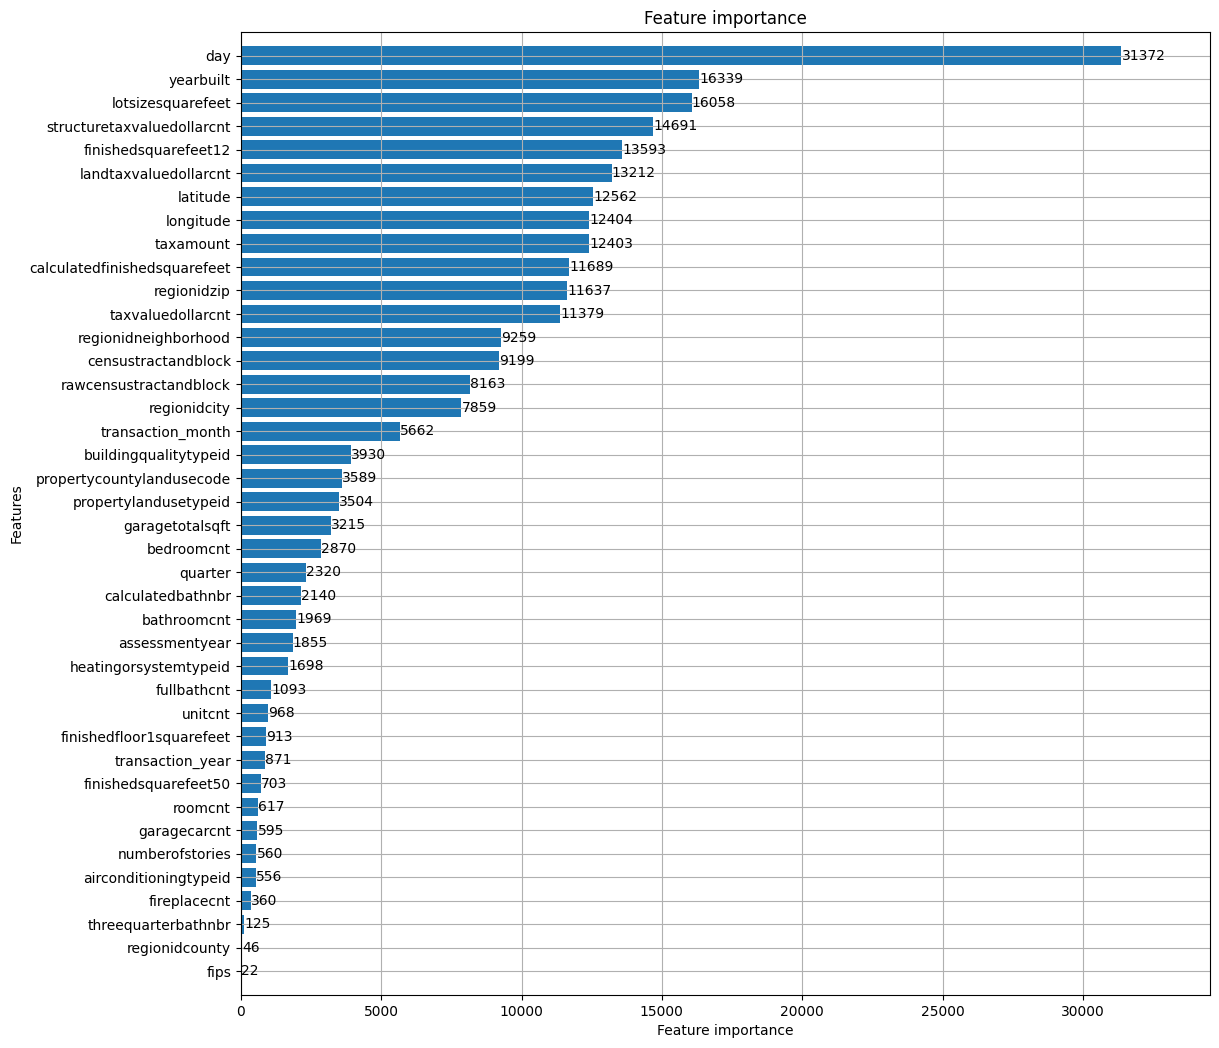

In [75]:
lgb.plot_importance(model, height=0.8, figsize=(12.5, 12.5), ignore_zero=False)

In [76]:
# Sanity check: make sure the model score is reasonable on a small portion of the data
print("score: {}".format(abs(model.predict(X_val) - y_val).mean() * 100))

score: 5.236197994690431


In [77]:
"""
    Helper method that prepares 2016 and 2017 properties features for inference
"""
def transform_test_features(features_2016, features_2017):
    test_features_2016 = features_2016
    test_features_2017 = features_2017
    for col in features_2016,features_2017: 
        if col not in remaining_col: 
            test_features_2016=test_features_2016.drop([col], axis=1)
            test_features_2017=test_features_2017.drop([col], axis=1)
    
    test_features_2016['transaction_year'] = 0
    test_features_2017['transaction_year'] = 1
    
    # 11 & 12 lead to unstable results, probably due to the fact that there are few training examples for them
    test_features_2016['transaction_month'] = 10
    test_features_2017['transaction_month'] = 10
    
    test_features_2016['quarter'] = 4
    test_features_2017['quarter'] = 4
    
    return test_features_2016, test_features_2017

"""
    Helper method that makes predictions on the test set and exports results to csv file
    'models' is a list of models for ensemble prediction (len=1 means using just a single model)
"""
def predict_and_export(models, features_2016, features_2017, file_name):
    # Construct DataFrame for prediction results
    submission_2016 = pd.DataFrame()
    submission_2017 = pd.DataFrame()
    submission_2016['ParcelId'] = features_2016.parcelid
    submission_2017['ParcelId'] = features_2017.parcelid
    
    test_features_2016, test_features_2017 = transform_test_features(features_2016, features_2017)
    
    pred_2016, pred_2017 = [], []
    for i, model in enumerate(models):
        print("Start model {} (2016)".format(i))
        pred_2016.append(model.predict(test_features_2016))
        print("Start model {} (2017)".format(i))
        pred_2017.append(model.predict(test_features_2017))
    
    # Take average across all models
    mean_pred_2016 = np.mean(pred_2016, axis=0)
    mean_pred_2017 = np.mean(pred_2017, axis=0)
    
    submission_2016['201610'] = [float(format(x, '.4f')) for x in mean_pred_2016]
    submission_2016['201611'] = submission_2016['201610']
    submission_2016['201612'] = submission_2016['201610']

    submission_2017['201710'] = [float(format(x, '.4f')) for x in mean_pred_2017]
    submission_2017['201711'] = submission_2017['201710']
    submission_2017['201712'] = submission_2017['201710']
    
    submission = submission_2016.merge(how='inner', right=submission_2017, on='ParcelId')
    
    print("Length of submission DataFrame: {}".format(len(submission)))
    print("Submission header:")
    print(submission.head())
    submission.to_csv(file_name, index=False)
    return submission, pred_2016, pred_2017

In [78]:
file_name = '/kaggle/working/submission.csv'
submission, pred_2016, pred_2017 = predict_and_export([model], features_2016, features_2017, file_name)

NameError: name 'features_2016' is not defined